# Ensemble model
0.5 m1 + 0.5 m2

In [129]:
#imports
import os
from copy import copy

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from hypopt import GridSearch
from hyperopt import tpe, fmin, space_eval, Trials, STATUS_OK, hp
from sklearn.model_selection import StratifiedShuffleSplit

import pickle

In [130]:
# configs.
%matplotlib inline
# version to read
read_version = "1.2.b - group zone"

# model to save
model_id = "4.2.0 - ensemble 3.2.0"

pd.set_option("display.max_columns", 500)

path = "../../data/split"
random_state = 42
print(os.listdir(path))

['1.2.b - group zone - 01-17 to 01-19 - df_train without nulls.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.1.b - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.1.a - df_test 04-19to05-19.feather', '1.1 - df_test 04-19to04-19.feather', '1.1.a - df_train  without nulls.feather', '1.1.a - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train without nulls.feather', '1.1.b - 01-17 to 01-19 - df_train only 2018 without nulls.feather', '1.1.b - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_train.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_val 02-19to03-19.feather', '1.1 - df_val 01-19to03-19.feather', '1.1.b - 01-17 to 01-19 - df_train with nan.feather', '1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to05-19.feather', '1.2.b - group zone - 01-17 to 01-19 - df_train with nan.feather', '1.1 - df_test 04-19to05-19.feather', '1.1.b - 01-1

## Loading models

In [131]:
# Loding the model

def load_model(model_file):
    """Load the dump model."""
    with open(model_file, "rb") as file:
        m = pickle.load(file)
    return m


def load_columns(columns_file):
    """Load the array of columns use in the dump model."""
    with open(columns_file, "rb") as file:
        columns = pickle.load(file)
    return columns

In [132]:
# model 1
model1_id = "3.2.0 - full 2018 adel with zone groups"
path_to_save = f"models/{model1_id}/"
model_file = os.path.join(path_to_save, f"{model1_id}.pickle")
columns_file = os.path.join(path_to_save, f"{model1_id} (COLUMNS) - n_features_54.pickle")

m1 = load_model(model_file)
columns1 = load_columns(columns_file)
print(len(columns1))

54


/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [133]:
# model 2
model2_id = "3.2.0 - only invest with zone groups recall"
path_to_save = f"models/{model2_id}/"
model_file = os.path.join(path_to_save, f"{model2_id}.pickle")
columns_file = os.path.join(path_to_save, f"{model2_id} (COLUMNS) - n_features_40.pickle")

m2 = load_model(model_file)
columns2 = load_columns(columns_file)
print(len(columns2))

40


/home/voolkia/anaconda3/lib/python3.6/site-packages/sklearn/base.py:251: UserWarning: Trying to unpickle estimator LabelEncoder from version 0.21.2 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


## Loading val set

In [134]:
df_val = pd.read_feather(os.path.join(path, f"{read_version} - 01-17 to 01-19 - df_val 02-19to03-19.feather"))

/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [135]:
pd.crosstab(df_val["TIPO_EXPED"], [df_val["EXISTE_FRAUDE"], df_val["total_condicion"] > 4], margins=True)

EXISTE_FRAUDE    False       True         All
total_condicion  False True False True       
TIPO_EXPED                                   
0                  388    3     2    0    393
1                 5310   36     7    0   5353
2                30889    6     3    0  30898
3                28171    0     4    0  28175
4                  933    0     1    0    934
5                  672  232    18    5    927
6                 4503  360    76  194   5133
All              70866  637   111  199  71813

In [136]:
X_test = df_val.drop(columns="EXISTE_FRAUDE")
y_test = df_val["EXISTE_FRAUDE"]

In [137]:
# model 1
to_drop = ["FECHA_SINI", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST"]
y_pred_1 = m1.predict_proba(X_test.drop(columns=to_drop))[:, 1]

In [139]:
tmp = df_val.copy()
tmp["y_pred"] = y_pred_1

pd.crosstab([tmp["es_gte_5"], tmp["TIPO_EXPED"]], [tmp["EXISTE_FRAUDE"], tmp["y_pred"] > 0.5])

EXISTE_FRAUDE        False       True       
y_pred               False True  False True 
es_gte_5 TIPO_EXPED                         
False    0             388     0     2     0
         1            5310     0     7     0
         2           30881     8     3     0
         3           27983   188     4     0
         4             928     5     1     0
         5             619    53    13     5
         6            4170   333    52    24
True     0               3     0     0     0
         1              36     0     0     0
         2               6     0     0     0
         5             196    36     4     1
         6               0   360     0   194

In [110]:
# model 2
y_pred_2 = m2.predict_proba(X_test[columns2])[:, 1]

In [111]:
# ensemble pred
def ensemble_pred(y_pred_1, y_pred_2):
    w1 = 0.5
    w2 = 1 - w1
    y_pred = (y_pred_1 * w1) + (y_pred_2 * w2)
    return y_pred

In [112]:
y_pred = ensemble_pred(y_pred_1, y_pred_2)

0.201, 0.949


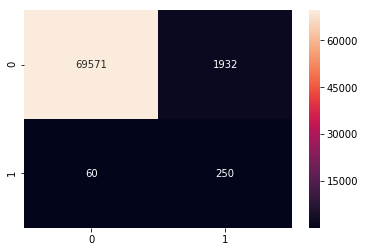

In [113]:
print("%.3f, %.3f" % (f1_score(y_test, y_pred > 0.5), roc_auc_score(y_test, y_pred)))
conf_mat = confusion_matrix(y_test, (y_pred > 0.5))
sns.heatmap(conf_mat, annot=True, fmt="d")

0.347, 0.817


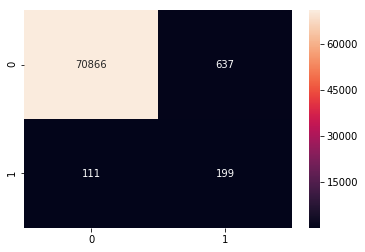

In [114]:
y_tronador = df_val["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

0.201, 0.949


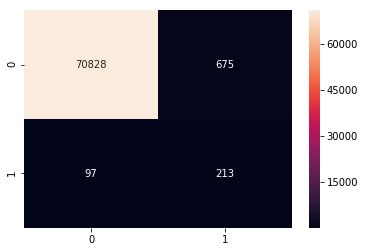

In [115]:
# limit total cond
print("%.3f, %.3f" % (f1_score(y_test, y_pred > 0.5), roc_auc_score(y_test, y_pred)))
conf_mat = confusion_matrix(y_test, ((y_pred > 0.5) & (df_val.total_condicion >= 3)))
sns.heatmap(conf_mat, annot=True, fmt="d")

In [116]:
tmp = df_val.copy()
tmp["y_pred"] = y_pred
#tmp = tmp[tmp.total_condicion >= 3]
# tmp = tmp[tmp.TIPO_EXPED >= 4]

pd.crosstab([tmp["TIPO_EXPED"]], [tmp["EXISTE_FRAUDE"], tmp["y_pred"] > 0.5]) # , tmp["total_condicion"]

EXISTE_FRAUDE  False       True       
y_pred         False True  False True 
TIPO_EXPED                            
0                391     0     2     0
1               5346     0     7     0
2              30887     8     3     0
3              27937   234     4     0
4                925     8     1     0
5                845    59    19     4
6               3240  1623    24   246

## Loading test set

In [117]:
df_test = pd.read_feather(os.path.join(path, "1.2.b - group zone - 01-17 to 01-19 - df_test 04-19to04-19.feather"))

/home/voolkia/anaconda3/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [118]:
pd.crosstab(df_test["TIPO_EXPED"], [df_test["EXISTE_FRAUDE"], df_test["total_condicion"]])

EXISTE_FRAUDE    False                                                     \
total_condicion   0.0   1.0  2.0  3.0  4.0  5.0  6.0  7.0  8.0  10.0 12.0   
TIPO_EXPED                                                                  
0                   42    94   18    4    3    2    0    0    0    0    0   
1                  804  1372  221  141   54    3    6    2    0    0    0   
2                13953  1768   77  255   40    1    0    0    0    0    0   
3                11098  1014   18  361   33    1    0    0    0    0    0   
4                  367    59    0    7    0    0    0    0    0    0    0   
5                    0     0    0  249   26   75   17    1    4    0    0   
6                 1595   134  239  251   17   80   23    3   15   11    2   

EXISTE_FRAUDE             True                                                \
total_condicion 13.0 15.0  0.0  1.0  2.0  3.0  5.0  6.0  7.0  8.0  9.0  10.0   
TIPO_EXPED                                                                     
0                  0    0     0    0    0    0    0    0    0    0    0    0   
1                  0    0     0    0    0    0    0    0    0    0    0    0   
2                  0    0     0    0    0    0    0    0    0    0    0    0   
3                  0    0     1    0    0    0    0    0    0    0    0    0   
4                  0    0     0    0    0    0    0    0    0    0    0    0   
5                  0    0     0    0    0    5    5    0    0    0    0    0   
6                  1    1    10    1    1   10   30    5    3    6    1    8   

EXISTE_FRAUDE                   
total_condicion 11.0 12.0 13.0  
TIPO_EXPED                      
0                  0    0    0  
1                  0    0    0  
2                  0    0    0  
3                  0    0    0  
4                  0    0    0  
5                  0    0    0  
6                  1    5    4

In [119]:
X_test = df_test.drop(columns="EXISTE_FRAUDE")
y_test = df_test["EXISTE_FRAUDE"]

### Pred model 1

In [120]:
to_drop = ["FECHA_SINI", "NUM_SECU_EXPED", "NUM_SECU_POL", "EXISTE_INVEST"]
y_pred_1 = m1.predict_proba(X_test.drop(columns=to_drop))[:, 1]

### Pred model 2

In [121]:
y_pred_2 = m2.predict_proba(X_test[columns2])[:, 1]

## making ensemble pred

In [122]:
y_pred = ensemble_pred(y_pred_1, y_pred_2)

0.150, 0.985


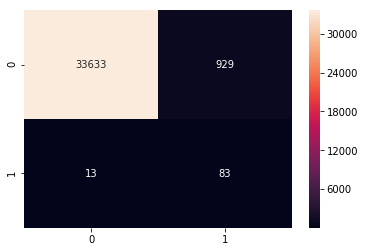

In [123]:
print("%.3f, %.3f" % (f1_score(y_test, y_pred > 0.5), roc_auc_score(y_test, y_pred)))
conf_mat = confusion_matrix(y_test, (y_pred > 0.5))
sns.heatmap(conf_mat, annot=True, fmt="d")

0.330, 0.851


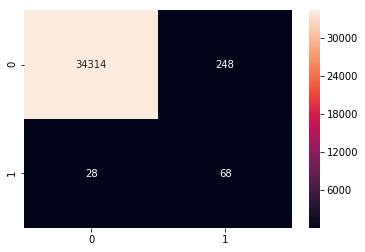

In [124]:
y_tronador = df_test["es_gte_5"]
print("%.3f, %.3f" % (f1_score(y_test, y_tronador), roc_auc_score(y_test, y_tronador)))
conf_mat = confusion_matrix(y_test, y_tronador)
sns.heatmap(conf_mat, annot=True, fmt="d")

### distrib

In [125]:
pd.crosstab(df_test["TIPO_EXPED"], [df_test["EXISTE_FRAUDE"], y_pred > 0.5])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
TIPO_EXPED                            
0                163     0     0     0
1               2603     0     0     0
2              16091     3     0     0
3              12396   129     1     0
4                430     3     0     0
5                352    20     5     5
6               1598   774     7    78

In [126]:
pd.crosstab(df_test["es_gte_5"], [df_test["EXISTE_FRAUDE"], y_pred > 0.5])

EXISTE_FRAUDE  False       True       
col_1          False True  False True 
es_gte_5                              
False          33530   784     9    19
True             103   145     4    64

# limitando el total_condicion

0.150, 0.985


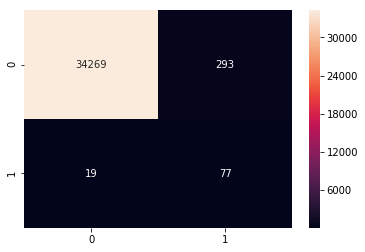

In [127]:
print("%.3f, %.3f" % (f1_score(y_test, y_pred > 0.5), roc_auc_score(y_test, y_pred)))
conf_mat = confusion_matrix(y_test, ((y_pred > 0.5) & (df_test.total_condicion >= 3)))
sns.heatmap(conf_mat, annot=True, fmt="d")

In [128]:
tmp = df_test.copy()
tmp["y_pred"] = y_pred
tmp = tmp[tmp.total_condicion >= 3]

pd.crosstab([tmp["es_gte_5"], tmp["TIPO_EXPED"]], [tmp["EXISTE_FRAUDE"], tmp["y_pred"] > 0.5])

EXISTE_FRAUDE       False       True       
y_pred              False True  False True 
es_gte_5 TIPO_EXPED                        
False    0              7     0     0     0
         1            195     0     0     0
         2            295     0     0     0
         3            392     2     0     0
         4              6     1     0     0
         5            264    11     1     4
         6            134   134     1     9
True     0              2     0     0     0
         1             11     0     0     0
         2              1     0     0     0
         3              1     0     0     0
         5             88     9     4     1
         6              0   136     0    63